This notebook is based on the file [Improving Neural Net Performance programming exercise](https://colab.research.google.com/notebooks/mlcc/improving_neural_net_performance.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=improvingneuralnets-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Improving Neural Net Performance

**Learning Objective:** Improve the performance of a neural network by normalizing features and applying various optimization algorithms

**NOTE:** The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

## Setup

First, we'll load the data.

In [1]:
using Plots
using StatPlots
using Distributions
gr()
using DataFrames
using TensorFlow
import CSV
import StatsBase
using PyCall

sess=Session(Graph())
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

2018-09-03 17:02:50.066566: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [2]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     :total_rooms,
     :total_bedrooms,
     :population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    
function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value] = (
    california_housing_dataframe[:median_house_value] ./ 1000.0)
  return output_targets
end

preprocess_targets (generic function with 1 method)

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(head(california_housing_dataframe,12000))
training_targets = preprocess_targets(head(california_housing_dataframe,12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(tail(california_housing_dataframe,5000))
validation_targets = preprocess_targets(tail(california_housing_dataframe,5000))

# Double-check that we've done the right thing.
println("Training examples summary:")
describe(training_examples)
println("Validation examples summary:")
describe(validation_examples)

println("Training targets summary:")
describe(training_targets)
println("Validation targets summary:")
describe(validation_targets)

Training examples summary:


,variable,mean,min,median,max,nunique,nmissing,eltype
1,median_house_value,210.168,25.0,182.35,500.001,,,Float64


Validation examples summary:
Training targets summary:
Validation targets summary:


## Train the Neural Network

Next, we'll set up the neural network similar to the previous exercise.

In [10]:
function construct_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: DataFrame of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Array, input_features[:,:])
  return convert.(Float64,out) 
end

construct_columns (generic function with 1 method)

In [4]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
  """Create batches.

  Args:
    features: Input features.
    targets: Target column.
    steps: Number of steps.
    batch_size: Batch size.
    num_epochs: Number of epochs, 0 will let TF automatically calculate the correct number
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """  
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)
    

    for i=1:num_epochs
        
        select=shuffle(1:size(features,1))
     
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else
            
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end
    
    return features_batches, target_batches 
end


function next_batch(features_batches, targets_batches, batch_size, iter)
  """Next batch.

  Args:
    features_batches: Features batches from create_batches.
    targets_batches: Target batches from create_batches.
    batch_size: Batch size.
    iter: Number of the current iteration
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """ 
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end

next_batch (generic function with 1 method)

In [6]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Prepares a batch of features and labels for model training.
  
    Args:
      features_batches: Features batches from create_batches.
      targets_batches: Target batches from create_batches.
      iter: Number of the current iteration
      batch_size: Batch size.
      shuffle_flag: Determines wether data is shuffled before being returned
    Returns:
      Tuple of (features, labels) for next data batch
    """  
                          
    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return ds, target
end

my_input_fn (generic function with 3 methods)

Now we can set up the neural network itself.

In [14]:
function train_nn_regression_model(my_optimizer,
                     steps, 
                     batch_size, 
                     hidden_units,
                     keep_probability,
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a neural network model of one feature.
  
  Args:
    my_optimizer: Optimizer function for the training step
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A vector describing the layout of the neural network
    keep_probability: A `float`, the probability of keeping a node active during one training step.
  Returns:
    p1: Plot of RMSE for the different periods
    training_rmse: Training RMSE values for the different periods
    validation_rmse: Validation RMSE values for the different periods
    
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32, shape=[-1, size(construct_columns(training_examples),2)])
  target_columns = placeholder(Float32, shape=[-1, size(construct_columns(training_targets),2)])
  
  # Network parameters
  push!(hidden_units,size(training_targets,2)) #create an output node that fits to the size of the targets
  activation_functions = Vector{Function}(size(hidden_units,1))
  activation_functions[1:end-1]=z->nn.dropout(nn.relu(z), keep_probability)
  activation_functions[end] = identity #Last function should be idenity as we need the logits  
    
  # create network - professional template
  Zs = [feature_columns]
  for (ii,(hlsize, actfun)) in enumerate(zip(hidden_units, activation_functions))
        Wii = get_variable("W_$ii"*randstring(4), [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii"*randstring(4), [hlsize], Float32)
        Zii = actfun(Zs[end]*Wii + bii)
        push!(Zs, Zii)
  end
   
  y=Zs[end]
  loss=reduce_sum((target_columns - y).^2)
 
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
    
  # Optimizer setup with gradient clipping
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
  run(sess, global_variables_initializer())
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_columns(features), target_columns=>construct_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> construct_columns(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> construct_columns(validation_examples)));  
                                   
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")
    
  #
  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final RMSE (on validation data): ", validation_rmse[end])
    
  return  p1, training_rmse, validation_rmse
end

train_nn_regression_model (generic function with 1 method)

Train the model with a Gradient Descent Optimizer and a learning rate of 0.0007.

In [11]:
p1, training_rmse, validation_rmse = train_nn_regression_model(
    train.GradientDescentOptimizer(0.0007), #optimizer & learning rate
    5000, #steps
    70, #batch_size
    [10, 10], #hidden_units
    1.0, # keep probability
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 163.180295637483
  period 2: 161.26135156851018
  period 3: 152.5080762133199
  period 4: 131.01682893731694
  period 5: 104.81629292310197
  period 6: 101.90063143465281
  period 7: 103.65539145744539
  period 8: 99.97967678136483
  period 9: 99.5169919104292
  period 10: 99.85829500231807
Model training finished.


(Plot{Plots.GRBackend() n=2}, Any[163.18, 161.261, 152.508, 131.017, 104.816, 101.901, 103.655, 99.9797, 99.517, 99.8583], Any[164.89, 162.075, 153.699, 132.176, 105.743, 102.463, 104.437, 100.265, 100.328, 100.597])

Final RMSE (on training data): 99.85829500231807
Final RMSE (on validation data): 100.59742834395213


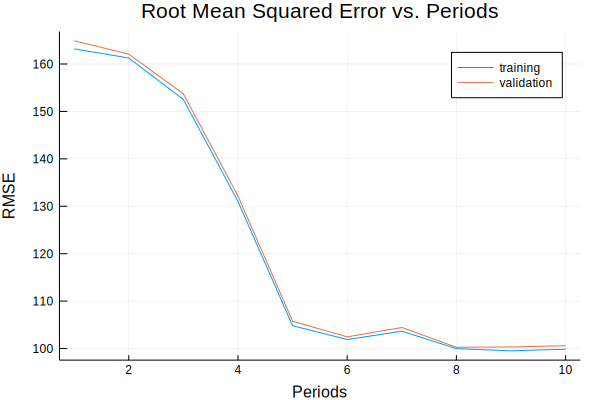

In [12]:
plot(p1)

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [13]:
function linear_scale(series)
  min_val = minimum(series)
  max_val = maximum(series)
  scale = (max_val - min_val) / 2.0
  return (series .- min_val) ./ scale .- 1.0
end

linear_scale (generic function with 1 method)

## Task 1: Normalize the Features Using Linear Scaling

**Normalize the inputs to the scale -1, 1.**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)


Since normalization uses min and max, we have to ensure it's done on the entire dataset at once. 

We can do that here because all our data is in a single DataFrame. If we had multiple data sets, a good practice would be to derive the normalization parameters from the training set and apply those identically to the test set.

In [15]:
function normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = DataFrame()
  processed_features[:latitude] = linear_scale(examples_dataframe[:latitude])
  processed_features[:longitude] = linear_scale(examples_dataframe[:longitude])
  processed_features[:housing_median_age] = linear_scale(examples_dataframe[:housing_median_age])
  processed_features[:total_rooms] = linear_scale(examples_dataframe[:total_rooms])
  processed_features[:total_bedrooms] = linear_scale(examples_dataframe[:total_bedrooms])
  processed_features[:population] = linear_scale(examples_dataframe[:population])
  processed_features[:households] = linear_scale(examples_dataframe[:households])
  processed_features[:median_income] = linear_scale(examples_dataframe[:median_income])
  processed_features[:rooms_per_person] = linear_scale(examples_dataframe[:rooms_per_person])
  return processed_features
end

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = head(normalized_dataframe, 12000)
normalized_validation_examples = tail(normalized_dataframe, 5000)

p1, graddescent_training_rmse, graddescent_validation_rmse = train_nn_regression_model(
    train.GradientDescentOptimizer(0.005),
    2000,
    50,
    [10, 10],
    1.0,
    normalized_training_examples,
    training_targets,
    normalized_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 116.09077765307714
  period 2: 106.39510919357569
  period 3: 92.2020458478069
  period 4: 78.05842296357487
  period 5: 75.76520735272948
  period 6: 74.19271740734389
  period 7: 72.9324235474891
  period 8: 72.26513417353931
  period 9: 71.69664884683169
  period 10: 71.22432996656671
Model training finished.


(Plot{Plots.GRBackend() n=2}, Any[116.091, 106.395, 92.202, 78.0584, 75.7652, 74.1927, 72.9324, 72.2651, 71.6966, 71.2243], Any[117.94, 108.035, 93.02, 77.7788, 75.1039, 73.3773, 71.9785, 71.1964, 70.5865, 70.0878])

Final RMSE (on training data): 71.22432996656671
Final RMSE (on validation data): 70.08780674123477


In [16]:
describe(normalized_dataframe)

,variable,mean,min,median,max,nunique,nmissing,eltype
1,latitude,-0.344267,-1.0,-0.636557,1.0,,,Float64
2,longitude,-0.0462367,-1.0,0.167331,1.0,,,Float64
3,housing_median_age,0.0819354,-1.0,0.0980392,1.0,,,Float64
4,total_rooms,-0.860727,-1.0,-0.887966,1.0,,,Float64
5,total_bedrooms,-0.832895,-1.0,-0.865611,1.0,,,Float64
6,population,-0.920033,-1.0,-0.934752,1.0,,,Float64
7,households,-0.83548,-1.0,-0.865812,1.0,,,Float64
8,median_income,-0.533292,-1.0,-0.580047,1.0,,,Float64
9,rooms_per_person,-0.928886,-1.0,-0.930325,1.0,,,Float64


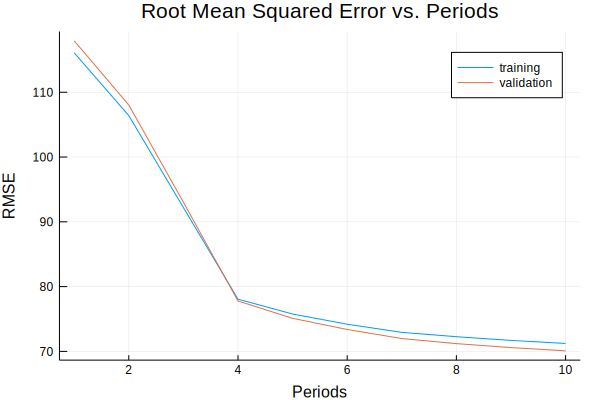

In [17]:
plot(p1)

## Task 2: Try a Different Optimizer

**Use the Momentum and Adam optimizers and compare performance.**

The Momentum optimizer is one alternative. The key insight of Momentum is that a gradient descent can oscillate heavily in case the sensitivity of the model to parameter changes is very different for different model parameters. So instead of just updating the weights and biases in the direction of reducing the loss for the current step, the optimizer combines it with the direction from the previous step. You can use Momentum by specifying `MomentumOptimizer` instead of `GradientDescentOptimizer`.  Note that you need to give two parameters - a learning rate and a "momentum" - with Momentum.

For non-convex optimization problems, Adam is sometimes an efficient optimizer.  To use Adam, invoke the `train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

First, let's try Momentum Optimizer.

In [42]:
p1, momentum_training_rmse, momentum_validation_rmse = train_nn_regression_model(
    train.MomentumOptimizer(0.005, 0.05),
    2000,
    50,
    [10, 10],
    1.0,
    normalized_training_examples,
    training_targets,
    normalized_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 112.6311447590545
  period 2: 108.05888663813701
  period 3: 100.13551755861181
  period 4: 85.68693847431287
  period 5: 82.32114201488704
  period 6: 78.33198134267947
  period 7: 76.201679958578
  period 8: 75.14959736130605
  period 9: 76.6816266464294
  period 

(Plot{Plots.GRBackend() n=2}, Any[112.631, 108.059, 100.136, 85.6869, 82.3211, 78.332, 76.2017, 75.1496, 76.6816, 74.2158], Any[114.764, 109.533, 101.738, 85.7742, 81.3485, 77.036, 74.8827, 73.7446, 75.1419, 72.7901])

10: 74.21582562782943
Model training finished.
Final RMSE (on training data): 74.21582562782943
Final RMSE (on validation data): 72.79005775397246


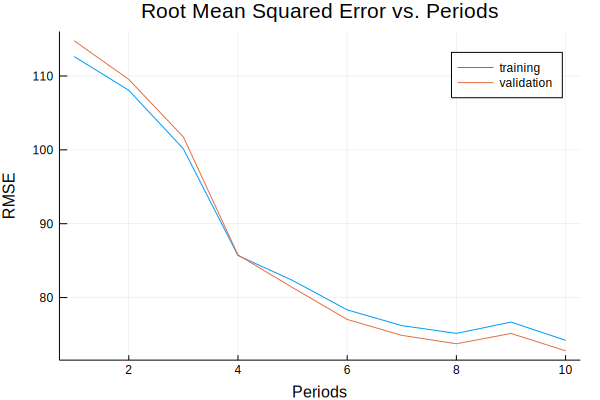

In [43]:
plot(p1)

Now let's try Adam.

In [52]:
p1, adam_training_rmse, adam_validation_rmse = train_nn_regression_model(
    train.AdamOptimizer(0.2),
    2000,
    50,
    [10, 10],
    1.0,
    normalized_training_examples,
    training_targets,
    normalized_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 72.64160867170764
  period 2: 71.12902983578199
  period 3: 77.11712739613068
  period 4: 68.69780346576317
  period 5: 76.85117566160234
  period 6: 74.97801908512282
  period 7: 74.08747095626799
  period 8: 89.26232409952414
  period 9: 67.50005522623385
  period 

(Plot{Plots.GRBackend() n=2}, Any[72.6416, 71.129, 77.1171, 68.6978, 76.8512, 74.978, 74.0875, 89.2623, 67.5001, 69.3121], Any[71.2033, 69.9634, 76.0729, 66.8816, 75.8678, 74.0505, 73.0449, 89.2644, 66.1359, 67.6034])

10: 69.3121128893884
Model training finished.
Final RMSE (on training data): 69.3121128893884
Final RMSE (on validation data): 67.60344861121533


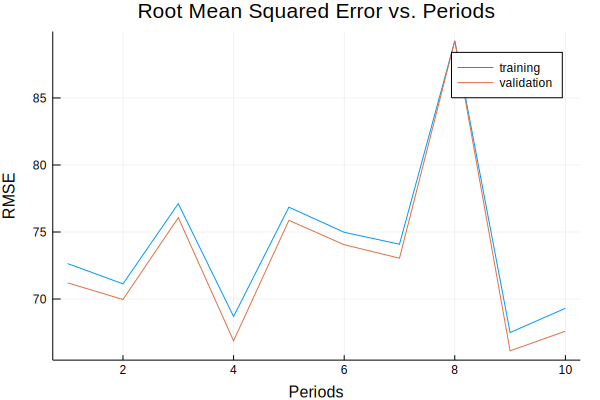

In [53]:
plot(p1)

Let's print a graph of loss metrics side by side.

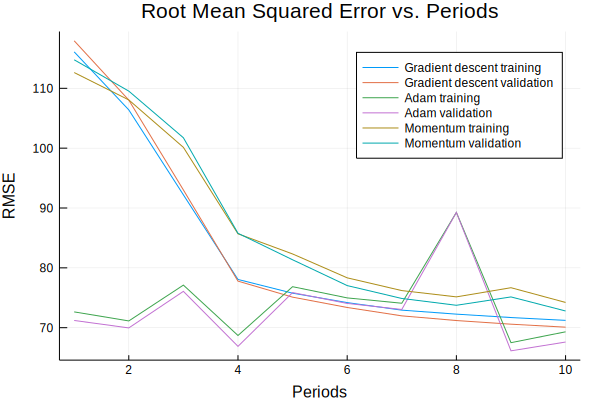

In [54]:
p2=plot(graddescent_training_rmse, label="Gradient descent training", ylabel="RMSE", xlabel="Periods", title="Root Mean Squared Error vs. Periods")
p2=plot!(graddescent_validation_rmse, label="Gradient descent validation")
p2=plot!(adam_training_rmse, label="Adam training")
p2=plot!(adam_validation_rmse, label="Adam validation")
p2=plot!(momentum_training_rmse, label="Momentum training")
p2=plot!(momentum_validation_rmse, label="Momentum validation")


## Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

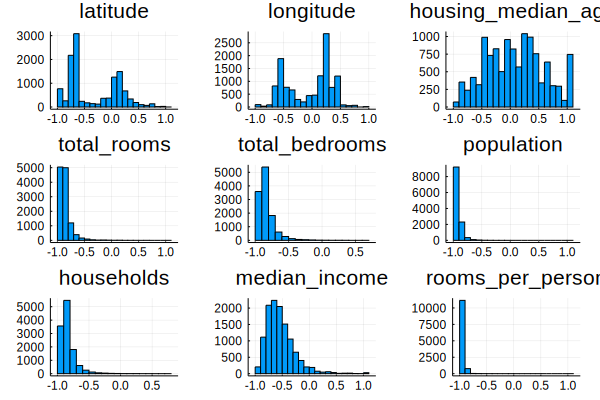

In [22]:
# I'd like a better solution to automate this, but all ideas for eval
# on quoted expressions failed :-()
hist1=histogram(normalized_training_examples[:latitude], bins=20,  title="latitude"  )
hist2=histogram(normalized_training_examples[:longitude], bins=20,  title="longitude"  )
hist3=histogram(normalized_training_examples[:housing_median_age], bins=20,  title="housing_median_age"  )
hist4=histogram(normalized_training_examples[:total_rooms], bins=20,  title="total_rooms"  )
hist5=histogram(normalized_training_examples[:total_bedrooms], bins=20,  title="total_bedrooms"  )
hist6=histogram(normalized_training_examples[:population], bins=20,  title="population"  )
hist7=histogram(normalized_training_examples[:households], bins=20,  title="households"  )
hist8=histogram(normalized_training_examples[:median_income], bins=20,  title="median_income"  )
hist9=histogram(normalized_training_examples[:rooms_per_person], bins=20,  title="rooms_per_person"  )

plot(hist1, hist2, hist3, hist4, hist5, hist6, hist7, hist8, hist9, layout=9, legend=false)


We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features.  Or clipping extreme values may make the remainder of the scale more informative.

In [23]:
function log_normalize(series)
  return log.(series.+1.0)
end

function clip(series, clip_to_min, clip_to_max)
  return min.(max.(series, clip_to_min), clip_to_max)
end

function z_score_normalize(series)
  mean_val = mean(series)
  std_dv = std(series, mean=mean_val)
  return (series .- mean) ./ std_dv
end

function binary_threshold(series, threshold)
  return map(x->(x > treshold ? 1 : 0), series)
end

binary_threshold (generic function with 1 method)

The block above contains a few additional possible normalization functions. 

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

These are only a few ways in which we could think about the data. Other transformations may work even better!

`households`, `median_income` and `total_bedrooms` all appear normally-distributed in a log space.

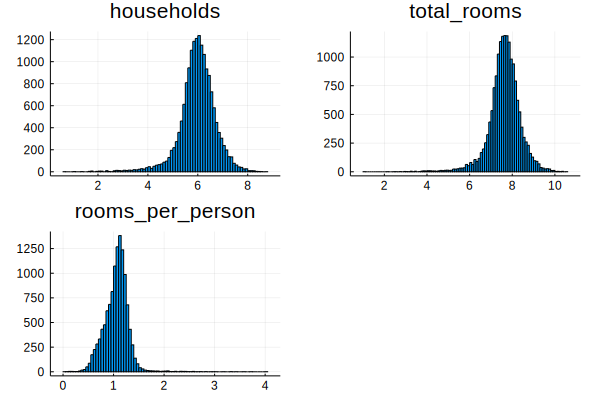

In [24]:
hist10=histogram(log_normalize(california_housing_dataframe[:households]), title="households")
hist11=histogram(log_normalize(california_housing_dataframe[:total_rooms]), title="total_rooms")
hist12=histogram(log_normalize(training_examples[:rooms_per_person]), title="rooms_per_person")
plot(hist10, hist11, hist12, layout=3, legend=false)

`latitude`, `longitude` and `housing_median_age` would probably be better off just scaled linearly, as before.

`population`, `total_rooms` and `rooms_per_person` have a few extreme outliers. They seem too extreme for log normalization to help. So let's clip them instead.

In [46]:
function normalize_df(examples_dataframe)
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = DataFrame()

  processed_features[:households] = log_normalize(examples_dataframe[:households])
  processed_features[:median_income] = log_normalize(examples_dataframe[:median_income])
  processed_features[:total_bedrooms] = log_normalize(examples_dataframe[:total_bedrooms])
  
  processed_features[:latitude] = linear_scale(examples_dataframe[:latitude])
  processed_features[:longitude] = linear_scale(examples_dataframe[:longitude])
  processed_features[:housing_median_age] = linear_scale(examples_dataframe[:housing_median_age])

  processed_features[:population] = linear_scale(clip(examples_dataframe[:population], 0, 5000))
  processed_features[:rooms_per_person] = linear_scale(clip(examples_dataframe[:rooms_per_person], 0, 5))
  processed_features[:total_rooms] = linear_scale(clip(examples_dataframe[:total_rooms], 0, 10000))

  return processed_features
end
    
normalized_dataframe = normalize_df(preprocess_features(california_housing_dataframe))
normalized_training_examples = head(normalized_dataframe,12000)
normalized_validation_examples = tail(normalized_dataframe,5000)

p1, adam_training_rmse, adam_validation_rmse = train_nn_regression_model(
    train.AdamOptimizer(0.15),
    2000,
    50,
    [10, 10],
    1.0,
    normalized_training_examples,
    training_targets,
    normalized_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 74.72096056179495
  period 2: 71.41889262056681
  period 3: 70.60752044614021
  period 4: 68.9509575179693
  period 5: 72.95804802579956
  period 6: 66.77946206351353
  period 7: 69.60194185199468
  period 8: 68.58383648972531
  period 9: 66.68706380224602
  period 

(Plot{Plots.GRBackend() n=2}, Any[74.721, 71.4189, 70.6075, 68.951, 72.958, 66.7795, 69.6019, 68.5838, 66.6871, 69.4884], Any[72.9878, 70.3855, 69.3093, 67.5559, 71.9222, 65.411, 68.4134, 67.2482, 65.4761, 68.2675])

10: 69.48840964307104
Model training finished.
Final RMSE (on training data): 69.48840964307104
Final RMSE (on validation data): 68.26751863022265


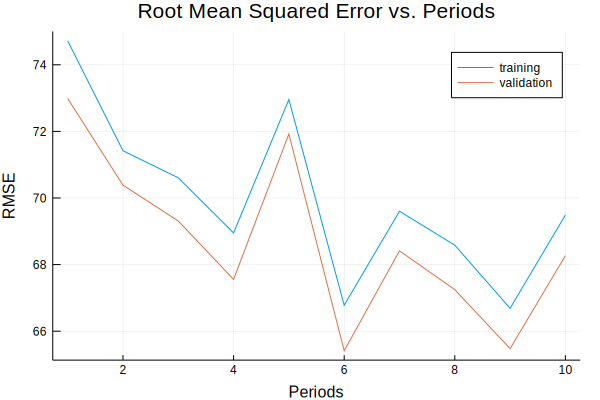

In [47]:
plot(p1)

## Optional Challenge: Use only Latitude and Longitude Features

**Train a NN model that uses only latitude and longitude as features.**

Real estate people are fond of saying that location is the only important feature in housing price.
Let's see if we can confirm this by training a model that uses only latitude and longitude as features.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

**NOTE:** We may need a network structure that has more layers than were useful earlier in the exercise.

It's a good idea to keep latitude and longitude normalized:

In [35]:
function location_location_location(examples_dataframe)
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = DataFrame()
  processed_features[:latitude] = linear_scale(examples_dataframe[:latitude])
  processed_features[:longitude] = linear_scale(examples_dataframe[:longitude])
  return processed_features
end

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = head(lll_dataframe,12000)
lll_validation_examples = tail(lll_dataframe,5000)

p1, lll_training_rmse, lll_validation_rmse = train_nn_regression_model(
    train.AdamOptimizer(0.15),
    500,
    100,
    [10, 10, 5, 5],
    1.0,
    lll_training_examples,
    training_targets,
    lll_validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 114.70454963731467
  period 2: 103.98212569567914
  period 3: 105.269708371533
  period 4: 99.07570050503281
  period 5: 109.85984129891541
  period 6: 99.30679344927408
  period 7: 98.08193175407696
  period 8: 98.14540308728282
  period 9: 107.40972986461607
  period 

(Plot{Plots.GRBackend() n=2}, Any[114.705, 103.982, 105.27, 99.0757, 109.86, 99.3068, 98.0819, 98.1454, 107.41, 103.183], Any[117.767, 106.149, 107.667, 100.831, 110.271, 101.503, 99.7394, 99.7085, 108.069, 105.764])

10: 103.18311789130752
Model training finished.
Final RMSE (on training data): 103.18311789130752
Final RMSE (on validation data): 105.76414082474946


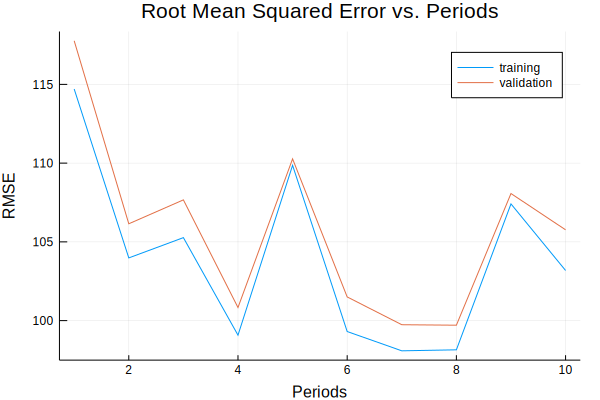

In [36]:
plot(p1)

This isn't too bad for just two features. Of course, property values can still vary significantly within short distances.

In [ ]:
#EOF